
# View Lucid Dreaming Core Session Data

This notebook loads and visualizes data recorded by the `app/main.py` application.
It reads the `session_metadata.npz` file for session information and then loads the corresponding
`eeg_eog_data.dat` and `aux_sensor_data.dat` binary files.


In [56]:

import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from frenztoolkit.reader import load_experiment

# Configure matplotlib for inline plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style for better aesthetics


In [57]:

# --- Configuration & Session Selection ---
BASE_RECORDING_FOLDER = "app/recorded_data"
METADATA_FILENAME = "session_metadata.npz"
EEG_EOG_DATA_FILENAME = "eeg_eog_data.dat"
AUX_SENSOR_DATA_FILENAME = "aux_sensor_data.dat"
EEG_DATA_TYPE = np.float32 # Should match what's in main.py

def list_session_folders(base_folder):
    if not os.path.isdir(base_folder):
        print(f"Error: Base recording folder not found: {base_folder}")
        return []
    sessions = sorted([d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))], reverse=True)
    return sessions

available_sessions = list_session_folders(BASE_RECORDING_FOLDER)
if not available_sessions:
    print(f"No session folders found in {BASE_RECORDING_FOLDER}")
else:
    print("Available sessions:")
    for i, session_id in enumerate(available_sessions):
        print(f"{i}: {session_id}")
    
    # Select a session (e.g., the latest one)
    selected_session_index = 0 # Or use input() for user to choose
    if 0 <= selected_session_index < len(available_sessions):
        SESSION_FOLDER_NAME = available_sessions[selected_session_index]
        SESSION_PATH = os.path.join(BASE_RECORDING_FOLDER, SESSION_FOLDER_NAME)
        print(f"\nSelected session: {SESSION_FOLDER_NAME}")
        print(f"Session path: {SESSION_PATH}")
    else:
        print("Invalid session index selected.")
        SESSION_PATH = None

Available sessions:
0: 20250527_000831_104560
1: 20250527_000757_939346
2: 20250526_234715_701464
3: 20250526_223152_730954
4: 20250526_205851_353747
5: 20250520_230403_168461
6: 20250520_223611_155605

Selected session: 20250527_000831_104560
Session path: app/recorded_data/20250527_000831_104560


In [58]:

# --- Load Metadata --- 
metadata = None
if SESSION_PATH and os.path.isdir(SESSION_PATH):
    metadata_filepath = os.path.join(SESSION_PATH, METADATA_FILENAME)
    if os.path.exists(metadata_filepath):
        try:
            metadata = np.load(metadata_filepath, allow_pickle=True)
            print("\n--- Session Metadata ---")
            for key, value in metadata.items():
                if key not in ['scores', 'eeg_eog_data_info', 'aux_sensor_data_info'] and not key.startswith("metadata_"):
                    print(f"{key}: {value}")
            
            if 'eeg_eog_data_info' in metadata:
                print("\nEEG/EOG Data Info:")
                for k,v in metadata['eeg_eog_data_info'].item().items(): # .item() if it's a 0-d array object
                    print(f"  {k}: {v}")
            if 'aux_sensor_data_info' in metadata:
                print("\nAuxiliary Sensor Data Info:")
                for k,v in metadata['aux_sensor_data_info'].item().items():
                    print(f"  {k}: {v}")
            
            # Store for later use
            eeg_eog_info = metadata['eeg_eog_data_info'].item() if 'eeg_eog_data_info' in metadata else None
            aux_info = metadata['aux_sensor_data_info'].item() if 'aux_sensor_data_info' in metadata else None
            sampling_frequency = metadata['sampling_frequency_hz'].item() if 'sampling_frequency_hz' in metadata else 250.0

        except Exception as e:
            print(f"Error loading metadata file {metadata_filepath}: {e}")
            metadata = None
    else:
        print(f"Metadata file not found: {metadata_filepath}")
else:
    print("Session path not set or invalid.")



--- Session Metadata ---
product_key: RUtYA4W3kpXi0i9C7VZCQJY5_GRhm4XL2rKp6cviwQI=
device_id: FRENZI40
session_start_iso: 2025-05-27T00:08:31.104560
sampling_frequency_hz: 125.0
audio_cue_timestamps: [1.74831898e+09 1.74831900e+09]

EEG/EOG Data Info:
  filename: eeg_eog_data.dat
  data_type: float32
  channel_names: ['RAW_EEG_LF', 'RAW_EEG_OTEL', 'RAW_EEG_REF1', 'RAW_EEG_RF', 'RAW_EEG_OTER', 'RAW_EEG_REF2', 'FILT_EEG_LF', 'FILT_EEG_OTEL', 'FILT_EEG_RF', 'FILT_EEG_OTER', 'FILT_EOG_CH1', 'FILT_EOG_CH2', 'FILT_EOG_CH3', 'FILT_EOG_CH4']
  num_channels: 14
  shape_on_save: channels_first

Auxiliary Sensor Data Info:
  filename: aux_sensor_data.dat
  data_type: float32
  channel_names: ['FILT_EMG_CH1', 'FILT_EMG_CH2', 'FILT_EMG_CH3', 'FILT_EMG_CH4', 'RAW_IMU_X', 'RAW_IMU_Y', 'RAW_IMU_Z', 'RAW_PPG_GREEN', 'RAW_PPG_RED', 'RAW_PPG_IR']
  num_channels: 10
  shape_on_save: channels_first


In [59]:

# --- Function to Load .dat Files ---
def load_dat_file(filepath, num_channels, total_samples, dtype=np.float32):
    if not os.path.exists(filepath):
        print(f"Data file not found: {filepath}")
        return None
    try:
        data_flat = np.fromfile(filepath, dtype=dtype)
        # Expected number of elements
        expected_elements = num_channels * total_samples
        if data_flat.size != expected_elements:
            print(f"Warning: File size mismatch for {filepath}. Expected {expected_elements} elements, got {data_flat.size}.")
            # Attempt to reshape with actual elements, might lead to incorrect total_samples if file is corrupt/incomplete
            # For robust handling, one might need to adjust total_samples or num_channels based on data_flat.size
            # For now, we'll try to reshape with the number of samples that fits the channel count
            if data_flat.size % num_channels == 0:
                actual_total_samples = data_flat.size // num_channels
                if actual_total_samples != total_samples:
                    print(f"Adjusting total samples for {filepath} from {total_samples} to {actual_total_samples} based on file size.")
                total_samples = actual_total_samples
            else:
                print(f"Error: Cannot reshape data for {filepath} as size {data_flat.size} is not divisible by num_channels {num_channels}.")
                return None
        
        # Reshape to (num_channels, total_samples)
        # Data was written as (channels, samples_in_block).tobytes(), so it's C-contiguous.
        reshaped_data = data_flat.reshape(num_channels, total_samples)
        return reshaped_data
    except Exception as e:
        print(f"Error loading or reshaping data file {filepath}: {e}")
        return None


In [60]:

# --- Load EEG/EOG Data ---
eeg_eog_data_loaded = None
if metadata and eeg_eog_info and SESSION_PATH:
    eeg_eog_data_filepath = os.path.join(SESSION_PATH, EEG_EOG_DATA_FILENAME)
    num_eeg_eog_channels = eeg_eog_info['num_channels']
    
    if 'metadata_eeg_eog_sample_counts' in metadata:
        total_eeg_eog_samples = np.sum(metadata['metadata_eeg_eog_sample_counts'])
        if total_eeg_eog_samples > 0:
            eeg_eog_data_loaded = load_dat_file(eeg_eog_data_filepath, num_eeg_eog_channels, total_eeg_eog_samples, dtype=EEG_DATA_TYPE)
            if eeg_eog_data_loaded is not None:
                print(f"\nLoaded EEG/EOG data. Shape: {eeg_eog_data_loaded.shape}")
    else:
        # We know the num channels and the data is 32-bit float
        # If sample counts are not found, we can calculate the total samples based on the file size
        file_size = os.path.getsize(eeg_eog_data_filepath)
        expected_elements = file_size // (num_eeg_eog_channels * np.dtype(EEG_DATA_TYPE).itemsize)
        print(f"File size: {file_size} bytes, expected elements: {expected_elements}")
        if expected_elements > 0:
            eeg_eog_data_loaded = load_dat_file(eeg_eog_data_filepath, num_eeg_eog_channels, expected_elements, dtype=EEG_DATA_TYPE)
            if eeg_eog_data_loaded is not None:
                print(f"\nLoaded EEG/EOG data. Shape: {eeg_eog_data_loaded.shape}")
        else:
            print("EEG/EOG sample counts not found in metadata.")



Loaded EEG/EOG data. Shape: (14, 14500)


In [61]:
# --- Print First 5 Rows of EEG/EOG Data ---
if eeg_eog_data_loaded is not None:
    print("First 5 rows of EEG/EOG data (channels x samples):")
    print(eeg_eog_data_loaded[:4, :])
else:
    print("EEG/EOG data not loaded.")

First 5 rows of EEG/EOG data (channels x samples):
[[-1.73960000e+04 -1.66870000e+04 -1.72850000e+04 ... -2.95780000e+04
  -3.01330000e+04 -3.02630000e+04]
 [ 1.45307000e+05  1.37025000e+05  1.52126000e+05 ... -2.56903076e+03
  -4.06048389e+03 -4.86462744e+03]
 [ 6.66129211e+02  5.64558716e+02  5.16641113e+02 ... -4.35331612e+01
  -4.35951424e+01 -4.22596512e+01]
 [-6.79127960e+01 -9.43940506e+01 -1.17888794e+02 ...  1.50111000e+05
   1.33813000e+05  1.48645000e+05]]


In [62]:

# --- Load Auxiliary Sensor Data ---
aux_data_loaded = None
if metadata and aux_info and SESSION_PATH:
    aux_data_filepath = os.path.join(SESSION_PATH, AUX_SENSOR_DATA_FILENAME)
    num_aux_channels = aux_info['num_channels']
    
    if 'metadata_aux_sample_counts' in metadata:
        total_aux_samples = np.sum(metadata['metadata_aux_sample_counts'])
        if total_aux_samples > 0:
            aux_data_loaded = load_dat_file(aux_data_filepath, num_aux_channels, total_aux_samples, dtype=EEG_DATA_TYPE)
            if aux_data_loaded is not None:
                print(f"\nLoaded Auxiliary sensor data. Shape: {aux_data_loaded.shape}")
        else:
            print("No Auxiliary sensor samples recorded according to metadata.")
    else:
        # We know the num channels and the data is 32-bit float
        # If sample counts are not found, we can calculate the total samples based on the file size
        file_size = os.path.getsize(aux_data_filepath)
        expected_elements = file_size // (num_aux_channels * np.dtype(EEG_DATA_TYPE).itemsize)
        print(f"File size: {file_size} bytes, expected elements: {expected_elements}")
        if expected_elements > 0:
            aux_data_loaded = load_dat_file(aux_data_filepath, num_aux_channels, expected_elements, dtype=EEG_DATA_TYPE)
            if aux_data_loaded is not None:
                print(f"\nLoaded Auxiliary sensor data. Shape: {aux_data_loaded.shape}")
        else:
            print("Auxiliary sensor sample counts not found in metadata.")



Loaded Auxiliary sensor data. Shape: (10, 14500)


In [63]:
# --- Print First 5 Rows of Auxiliary Sensor Data ---
if aux_data_loaded is not None:
    print("First 5 rows of Auxiliary sensor data (channels x samples):")
    print(aux_data_loaded[:5, :])
else:
    print("Auxiliary sensor data not loaded.")


First 5 rows of Auxiliary sensor data (channels x samples):
[[ 1.6442768e+01  2.0507692e+02  2.1997417e+02 ... -2.2264375e+02
  -2.1391562e+02 -1.7594063e+02]
 [ 6.9824997e+01  7.6256248e+01  8.2228127e+01 ...  4.9208092e+01
   3.8258549e+01  4.5707371e+01]
 [ 6.6434546e+00 -1.3795782e+01  4.9884476e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.2162200e+05  1.2163400e+05  1.2165400e+05 ...  7.5659180e+00
  -6.4723963e-01 -6.1363211e+00]
 [-5.7850623e+02 -5.9121564e+02 -5.7988440e+02 ...  2.0912000e+05
   2.0912000e+05  2.0912000e+05]]


2025-05-27T00:08:31.104560

--- Saved Scores (from session_metadata.npz) ---

Score: array__sleep_stage (Length: 3)
[0 0 0]

Score: array__poas (Length: 3)
[1.58032321e-06 1.46816249e-04 4.35285903e-03]

Score: array__posture (Length: 23), First 10 values: ['upright' 'upright' 'upright' 'upright' 'upright' 'upright' 'upright'
 'upright' 'upright' 'upright']

Score: array__focus_score (Length: 58), First 10 values: [40.         40.         40.         40.         40.         40.
 39.52490664 38.59857124 37.57236689 35.8639437 ]

Score: array__sqc_scores (Length: 23), First 10 values: [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


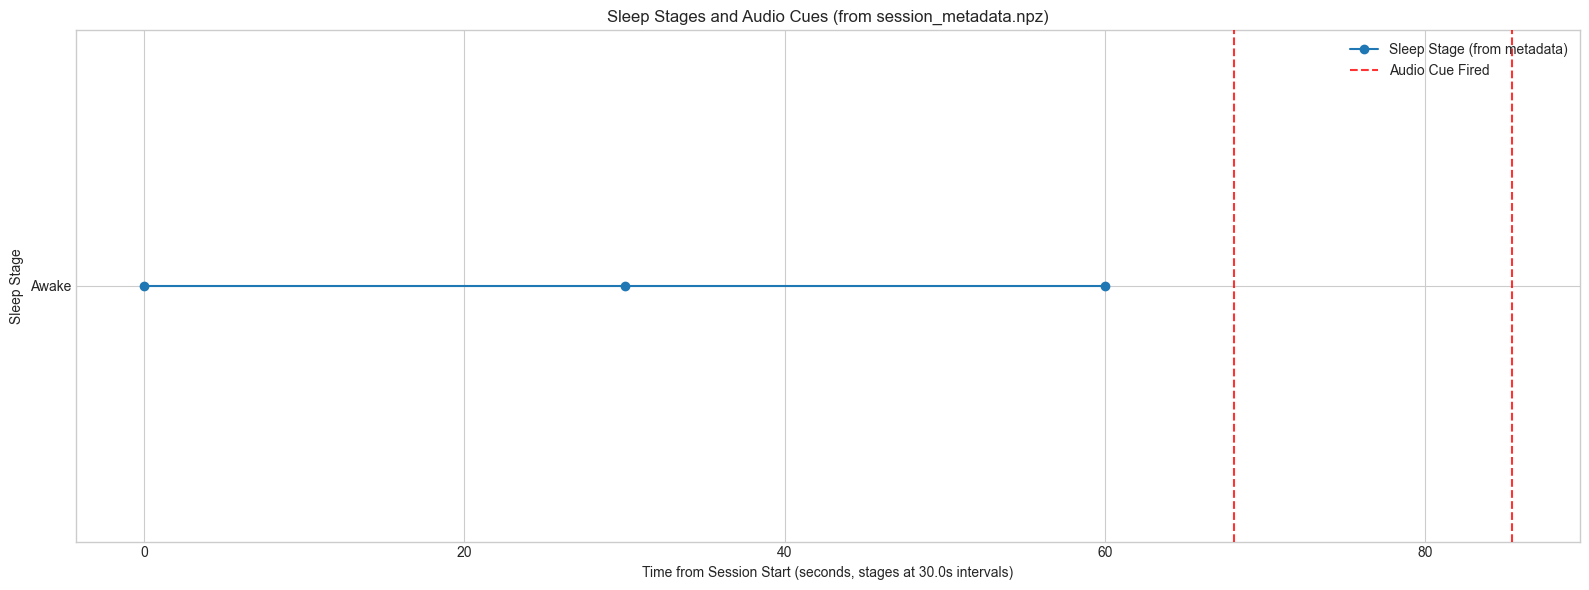


Audio Cues Fired (absolute timestamps): [1.74831898e+09 1.74831900e+09]
Audio Cues Fired (seconds from session start): [68.02 85.38]


In [64]:
# --- Display Scores and Audio Cues ---
if metadata and 'scores' in metadata and 'session_start_iso' in metadata:
    scores_dict = metadata['scores'].item()
    print(metadata['session_start_iso'])
    session_start_iso_str = str(metadata['session_start_iso'].item())
    # Use .get() for audio_cue_timestamps as it might not exist in older metadata
    audio_cue_timestamps_abs = metadata.get('audio_cue_timestamps') 

    print("\n--- Saved Scores (from session_metadata.npz) ---")
    for score_name, score_array in scores_dict.items():
        # Limiting verbose printing of entire score arrays
        if isinstance(score_array, np.ndarray) and score_array.size > 10:
            print(f"\nScore: {score_name} (Length: {len(score_array) if hasattr(score_array, '__len__') else 'N/A'}), First 10 values: {score_array[:10]}")
        else:
            print(f"\nScore: {score_name} (Length: {len(score_array) if hasattr(score_array, '__len__') else 'N/A'})")
            print(score_array)

    sleep_stages = scores_dict.get("array__sleep_stage")

    if sleep_stages is not None and hasattr(sleep_stages, '__len__') and len(sleep_stages) > 0:
        # Convert session_start_iso to UNIX timestamp
        try:
            session_start_dt = datetime.fromisoformat(session_start_iso_str)
            session_start_timestamp = session_start_dt.timestamp()
            valid_start_time = True
        except ValueError:
            print(f"Error: session_start_iso '{session_start_iso_str}' is not a valid ISO format. Cannot calculate relative cue times.")
            valid_start_time = False

        # Create time axis for sleep stages (assuming 30s per stage)
        # This interval might need adjustment based on actual Frenzband behavior.
        SLEEP_STAGE_INTERVAL_S = 30.0 
        sleep_stage_time_axis_s = np.arange(len(sleep_stages)) * SLEEP_STAGE_INTERVAL_S

        plt.figure(figsize=(16, 6)) # Adjusted figure size
        
        # Plot sleep stages
        plt.plot(sleep_stage_time_axis_s, sleep_stages, marker='o', linestyle='-', label='Sleep Stage (from metadata)')
        
        current_ylim = plt.ylim() # Capture y-limits after plotting sleep stages

        # Plot audio cues if available, not empty, and start time is valid
        plotted_cues = False
        if valid_start_time and audio_cue_timestamps_abs is not None and hasattr(audio_cue_timestamps_abs, '__len__') and len(audio_cue_timestamps_abs) > 0:
            # Ensure audio_cue_timestamps_abs is a numpy array of floats for calculations
            if not isinstance(audio_cue_timestamps_abs, np.ndarray) or audio_cue_timestamps_abs.dtype != np.float64:
                 audio_cue_timestamps_abs = np.array(audio_cue_timestamps_abs, dtype=np.float64)
            
            relative_audio_cue_times_s = audio_cue_timestamps_abs - session_start_timestamp
            
            plt.vlines(relative_audio_cue_times_s, ymin=current_ylim[0], ymax=current_ylim[1], 
                       colors='red', linestyles='dashed', label='Audio Cue Fired', zorder=5, alpha=0.8)
            # Optional: add markers at the top/bottom of vlines for better visibility
            # plt.scatter(relative_audio_cue_times_s, np.full_like(relative_audio_cue_times_s, current_ylim[1]), 
            #             marker='v', color='red', s=50, zorder=6, label='_nolegend_') # Use _nolegend_ to avoid duplicate legend entry
            plotted_cues = True
        
        plt.title("Sleep Stages and Audio Cues (from session_metadata.npz)")
        plt.xlabel(f"Time from Session Start (seconds, stages at {SLEEP_STAGE_INTERVAL_S}s intervals)")
        plt.ylabel("Sleep Stage")
        # value < 0: undefined, value = 0: awake, value = 1: light, value = 2: deep, value = 3: REM
        plt.yticks([-1, 0, 1, 2, 3], ['Undefined', 'Awake', 'Light', 'Deep', 'REM'])
        plt.legend() # Legend will adapt based on what was plotted
        plt.grid(True)
        plt.ylim(current_ylim) # Re-apply ylim in case vlines changed it or if no cues were plotted
        plt.tight_layout()
        plt.show()

        if valid_start_time and audio_cue_timestamps_abs is not None:
            if hasattr(audio_cue_timestamps_abs, '__len__') and len(audio_cue_timestamps_abs) > 0:
                print(f"\nAudio Cues Fired (absolute timestamps): {audio_cue_timestamps_abs}")
                relative_cues_for_print = audio_cue_timestamps_abs - session_start_timestamp
                print(f"Audio Cues Fired (seconds from session start): {np.round(relative_cues_for_print, 2)}")
            elif plotted_cues == False : # Cues were not plotted but the key existed (e.g. empty list)
                print("\nAudio cue timestamp data found but was empty. No cues plotted.")
        elif audio_cue_timestamps_abs is None:
             print("\nAudio cue timestamps (key 'audio_cue_timestamps') not found in metadata. Cannot plot cues.")

    elif sleep_stages is not None: # It exists but is empty
        print("Sleep stage data in metadata is empty. Cannot plot.")
    else: # sleep_stages is None
        print("Sleep stage data ('array__sleep_stage') not found in metadata scores. Cannot plot sleep stages and cues from metadata.")

elif not metadata:
    print("Metadata object not loaded. Cannot process scores or cues.")
elif 'scores' not in metadata :
    print("Key 'scores' not found in metadata.")
elif 'session_start_iso' not in metadata :
    print("Key 'session_start_iso' not found in metadata (needed for plotting audio cues relative to session start).")

# Fallback to frenztoolkit for loading session data if the above conditions weren't fully met for plotting from metadata
# This part will not show the custom audio cues from metadata.npz
if not (metadata and 'scores' in metadata and metadata['scores'].item().get("array__sleep_stage") is not None and \
    len(metadata['scores'].item().get("array__sleep_stage")) > 0 and 'session_start_iso' in metadata) :
    
    print("\n--- Attempting Fallback: Load Sleep Stages with Frenz Toolkit ---")
    if SESSION_PATH and os.path.isdir(SESSION_PATH):
        # Try to find a subfolder that might contain Frenz experiment data
        session_subfolders = [d for d in os.listdir(SESSION_PATH) if os.path.isdir(os.path.join(SESSION_PATH, d))]
        
        if session_subfolders:
            # Assuming the first subfolder is the relevant one for Frenz data, this might need adjustment
            session_subfolder_for_frenz = os.path.join(SESSION_PATH, session_subfolders[0])
            print(f"Attempting to load Frenz experiment data from subfolder: {session_subfolder_for_frenz}")
            
            try:
                session_data = load_experiment(session_subfolder_for_frenz)
                sleep_stage_list = session_data.get("SCORE", {}).get("array__sleep_stage")

                if sleep_stage_list is not None and len(sleep_stage_list) > 0:
                    plt.figure(figsize=(12, 3))
                    SLEEP_STAGE_INTERVAL_S_FRENZ = 30.0 # Assuming same interval for Frenz data
                    score_time_axis = np.arange(len(sleep_stage_list)) * SLEEP_STAGE_INTERVAL_S_FRENZ
                    plt.plot(score_time_axis, sleep_stage_list, marker='o', linestyle='-')
                    plt.title("Sleep Stages Over Session (from Frenz Toolkit data)")
                    plt.xlabel(f"Time (seconds, assuming {SLEEP_STAGE_INTERVAL_S_FRENZ}s epochs)")
                    plt.ylabel("Sleep Stage")
                    plt.yticks([-1, 0, 1, 2, 3], ['Undefined', 'Awake', 'Light', 'Deep', 'REM'])
                    plt.grid(True)
                    plt.show()
                else:
                    print("No sleep stage data available in Frenz Toolkit session data or data format unexpected.")
            except FileNotFoundError:
                print(f"Frenz experiment data not found in expected subfolder: {session_subfolder_for_frenz}")
            except Exception as e:
                print(f"Error loading or plotting data using Frenz Toolkit: {e}")
        else:
            print(f"No subdirectories found in {SESSION_PATH} to attempt loading Frenz experiment data from.")
    else:
        print("SESSION_PATH not set, cannot attempt Frenz Toolkit fallback.")